## Summary

The dataset consists of 1,781 entries and 79 attributes. It includes financial fundamentals for various companies, such as:
* Accounts Payable
* Accounts Receivable
* Net Income
* Total Revenue
* Profit Margin

The primary objective of this analysis is to explore financial data using unsupervised learning techniques, focusing on clustering. By employing methods such as K-means and Agglomerative Clustering, the aim is to identify patterns and segment companies based on their financial attributes. These insights can help stakeholders, such as investors or financial analysts, make more informed decisions by revealing underlying trends in company performance and financial health.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from scipy.cluster import hierarchy
from sklearn.metrics import confusion_matrix

# Mute the sklearn and IPython warnings
import warnings
warnings.filterwarnings('ignore', module='sklearn')
pd.options.display.float_format = '{:.2f}'.format

In [2]:
data = pd.read_csv('fundamentals.csv', sep=',')
data.head()

,Unnamed: 0,Ticker Symbol,Period Ending,Accounts Payable,Accounts Receivable,Add'l income/expense items,After Tax ROE,Capital Expenditures,Capital Surplus,Cash Ratio,...,Total Current Assets,Total Current Liabilities,Total Equity,Total Liabilities,Total Liabilities & Equity,Total Revenue,Treasury Stock,For Year,Earnings Per Share,Estimated Shares Outstanding
0,0,AAL,2012-12-31,3068000000.00,-222000000.00,-1961000000.00,23.00,-1888000000.00,4695000000.00,53.00,...,7072000000.00,9011000000.00,-7987000000.00,24891000000.00,16904000000.00,24855000000.00,-367000000.00,2012.00,-5.60,335000000.00
1,1,AAL,2013-12-31,4975000000.00,-93000000.00,-2723000000.00,67.00,-3114000000.00,10592000000.00,75.00,...,14323000000.00,13806000000.00,-2731000000.00,45009000000.00,42278000000.00,26743000000.00,0.00,2013.00,-11.25,163022222.22
2,2,AAL,2014-12-31,4668000000.00,-160000000.00,-150000000.00,143.00,-5311000000.00,15135000000.00,60.00,...,11750000000.00,13404000000.00,2021000000.00,41204000000.00,43225000000.00,42650000000.00,0.00,2014.00,4.02,716915422.89
3,3,AAL,2015-12-31,5102000000.00,352000000.00,-708000000.00,135.00,-6151000000.00,11591000000.00,51.00,...,9985000000.00,13605000000.00,5635000000.00,42780000000.00,48415000000.00,40990000000.00,0.00,2015.00,11.39,668129938.54
4,4,AAP,2012-12-29,2409453000.00,-89482000.00,600000.00,32.00,-271182000.00,520215000.00,23.00,...,3184200000.00,2559638000.00,1210694000.00,3403120000.00,4613814000.00,6205003000.00,-27095000.00,2012.00,5.29,73283553.88


In [3]:
data.shape

(1781, 79)

In [4]:
data.isnull().sum()

Unnamed: 0                        0
Ticker Symbol                     0
Period Ending                     0
Accounts Payable                  0
Accounts Receivable               0
                               ... 
Total Revenue                     0
Treasury Stock                    0
For Year                        173
Earnings Per Share              219
Estimated Shares Outstanding    219
Length: 79, dtype: int64

In [5]:
data.dtypes.value_counts()

float64    76
object      2
int64       1
Name: count, dtype: int64

In [6]:
data.dtypes

Unnamed: 0                        int64
Ticker Symbol                    object
Period Ending                    object
Accounts Payable                float64
Accounts Receivable             float64
                                 ...   
Total Revenue                   float64
Treasury Stock                  float64
For Year                        float64
Earnings Per Share              float64
Estimated Shares Outstanding    float64
Length: 79, dtype: object

## Data Exploration and Feature Engineering

#### Data Cleaning:
* Removed columns that were non-numeric or had null values.
* Transformed the Net Income column into a binary target:
1: Profit
0: Loss

#### Handling Skewness:
* Identified columns with high skewness (e.g., Pre-Tax ROE, After Tax ROE).
* Applied logarithmic transformations to normalize the distributions.

#### Scaling:
* Standardized all numerical columns using StandardScaler to ensure fair weightage during clustering.

Drop all the columns with null values and columns that aren't float

In [7]:
data.drop(['Unnamed: 0', 'Ticker Symbol', 'Period Ending'],axis = 1, inplace=True)
data.dropna(axis=1,inplace=True)

In [8]:
data['Net Income']

0      -1876000000.00
1      -1834000000.00
2       2882000000.00
3       7610000000.00
4        387670000.00
            ...      
1776     309471000.00
1777     504000000.00
1778     583000000.00
1779     339000000.00
1780     821000000.00
Name: Net Income, Length: 1781, dtype: float64

Setting the column 'Net Income' values to 1 if it the value was bigger than 0 (profit) and setting to 0 if the value was smaller thant 0 (loss)

In [9]:
data['Net Income'] = data['Net Income'].apply(lambda x : 1 if x > 0 else 0)

In [10]:
data['Net Income'].value_counts()

Net Income
1    1679
0     102
Name: count, dtype: int64

Identifing the columns with a high skewness and log transforming them

In [11]:
log_columns = data.skew().sort_values(ascending=False)
log_columns = log_columns.loc[log_columns > 0.75]
log_columns

Pre-Tax ROE                                           18.00
After Tax ROE                                         15.98
Other Operating Activities                            15.83
Minority Interest                                     15.77
Equity Earnings/Loss Unconsolidated Subsidiary        14.91
Accounts Receivable                                   14.46
Common Stocks                                         12.15
Short-Term Debt / Current Portion of Long-Term Debt   11.88
Non-Recurring Items                                   11.80
Long-Term Debt                                        11.36
Interest Expense                                      11.28
Other Liabilities                                     11.07
Short-Term Investments                                10.87
Cash and Cash Equivalents                             10.11
Intangible Assets                                     10.03
Add'l income/expense items                             9.98
Other Current Liabilities               

In [12]:
for col in log_columns.index:
    data[col] = np.log1p(data[col])

C:\Users\Rodrigo\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


Scaling the data

In [13]:
data.isnull().sum()

Accounts Payable                 0
Accounts Receivable           1072
Add'l income/expense items     509
After Tax ROE                    0
Capital Expenditures             0
                              ... 
Total Equity                    52
Total Liabilities                0
Total Liabilities & Equity       0
Total Revenue                    0
Treasury Stock                   0
Length: 70, dtype: int64

Once again dropping columns with null values

In [14]:
data.dropna(axis=1,inplace=True)

In [15]:
sc = StandardScaler()
feature_columns = [x for x in data.columns if x not in 'Net Income']
for col in feature_columns:
    data[col] = sc.fit_transform(data[[col]])

data.head()

,Accounts Payable,After Tax ROE,Capital Expenditures,Cash and Cash Equivalents,Changes in Inventories,Common Stocks,Cost of Revenue,Deferred Asset Charges,Deferred Liability Charges,Effect of Exchange Rate,...,Sale and Purchase of Stock,Short-Term Debt / Current Portion of Long-Term Debt,Short-Term Investments,Total Assets,Total Current Assets,Total Current Liabilities,Total Liabilities,Total Liabilities & Equity,Total Revenue,Treasury Stock
0,0.35,0.30,-0.21,0.24,0.17,0.53,0.42,-0.84,0.58,0.24,...,0.28,0.68,1.48,0.26,0.52,0.60,0.61,0.01,0.84,0.25
1,0.48,1.39,-0.63,0.51,0.17,-0.11,0.43,-0.84,0.73,0.24,...,0.28,0.68,1.57,0.70,0.60,0.65,1.00,0.70,0.90,0.28
2,0.47,2.17,-1.36,0.40,0.17,-0.04,0.49,-0.84,0.71,0.24,...,-0.10,0.70,1.54,0.71,0.58,0.65,0.94,0.71,1.28,0.28
3,0.49,2.11,-1.64,0.13,0.17,-0.07,0.43,1.41,0.69,0.24,...,-1.12,0.74,1.54,0.80,0.56,0.65,0.97,0.80,1.25,0.28
4,0.28,0.63,0.33,-0.20,-0.49,-1.41,0.20,-0.84,-1.43,0.24,...,0.27,-0.27,-0.77,-0.96,0.42,0.45,-0.72,-0.96,-0.28,0.28


## Train models

### K-means

In [16]:
km = KMeans(n_clusters=2, random_state=42)
km = km.fit(data[feature_columns])

In [17]:
data['kmeans'] = km.predict(data[feature_columns])

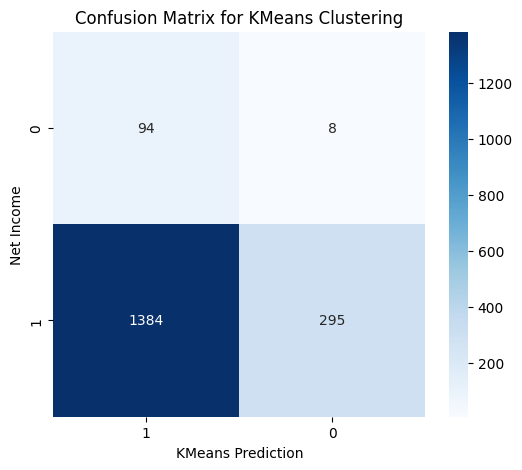

In [24]:
true_labels = data['Net Income']  # True labels (Net Income transformed to binary)
predicted_labels = data['kmeans']  # Predicted labels from KMeans

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix using seaborn's heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['1', '0'], yticklabels=['0', '1'])
plt.title('Confusion Matrix for KMeans Clustering')
plt.xlabel('KMeans Prediction')
plt.ylabel('Net Income')
plt.show()

### Agglomerative Clustering linkage ward

In [19]:
agw = AgglomerativeClustering(n_clusters=2, linkage='ward', compute_full_tree=True)
agw = agw.fit(data[feature_columns])
data['agglom_ward'] = agw.fit_predict(data[feature_columns])

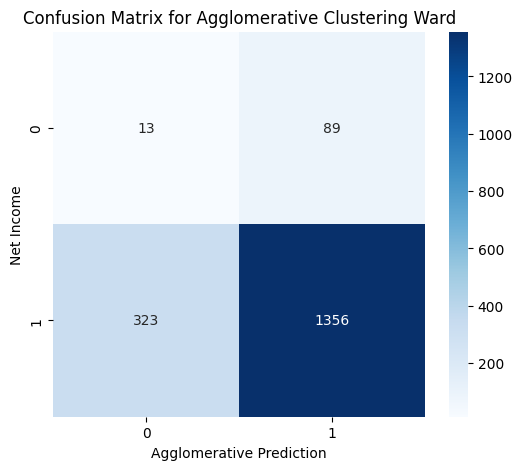

In [20]:
true_labels = data['Net Income']  # True labels (Net Income transformed to binary)
predicted_labels = data['agglom_ward']  # Predicted labels from KMeans

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix using seaborn's heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.title('Confusion Matrix for Agglomerative Clustering Ward')
plt.xlabel('Agglomerative Prediction')
plt.ylabel('Net Income')
plt.show()

### Agglomerative Clustering linkage complete

In [21]:
agc = AgglomerativeClustering(n_clusters=2, linkage='complete', compute_full_tree=True)
agc = agc.fit(data[feature_columns])
data['agglom_complete'] = agc.fit_predict(data[feature_columns])

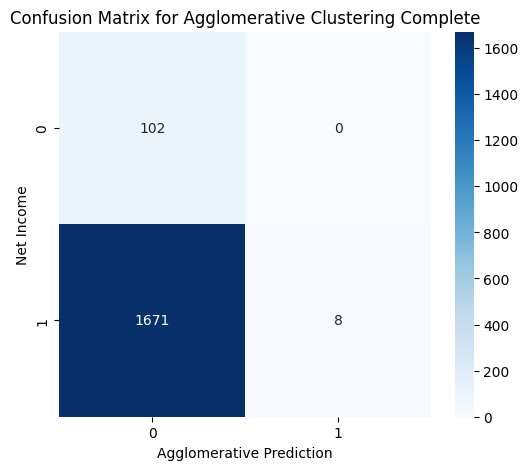

In [22]:
true_labels = data['Net Income']  # True labels (Net Income transformed to binary)
predicted_labels = data['agglom_complete']  # Predicted labels from KMeans

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix using seaborn's heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.title('Confusion Matrix for Agglomerative Clustering Complete')
plt.xlabel('Agglomerative Prediction')
plt.ylabel('Net Income')
plt.show()

## Results

Based on the analysis, K-Means Clustering is recommended as the final model for this task. It offers:

* Clear and interpretable cluster assignments.
* Strong alignment with the binary classification of Net Income.
* Computational efficiency compared to Agglomerative Clustering.

## Next Steps

Some possible next steps are:

* Investigating other clustering methods like DBSCAN.
* Using domain-specific data features to improve clustering quality.
* Expanding the analysis with supervised learning if labels are acquired.